In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# keras import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#set figure size
plt.rcParams['figure.figsize'] = 12, 6
sns.set_style('white')

# others
from random import randrange
from time import time

In [2]:
n_epochs = 30 # 30 
n_epochs_cv = 10 # 10  # reduce number of epochs for cross validation for performance reason

n_cv = 3
validation_ratio = 0.10

In [3]:
# load dataset and check dimension
data_set = pd.read_csv('/home/jeff/Desktop/WD18/grid_kaggle/train.csv')
print(data_set.shape)

(42000, 785)


In [4]:
data_set.sample(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
30632,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19429,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38211,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/home/jeff/anaconda3/envs/tf-gpu-apps-102920/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


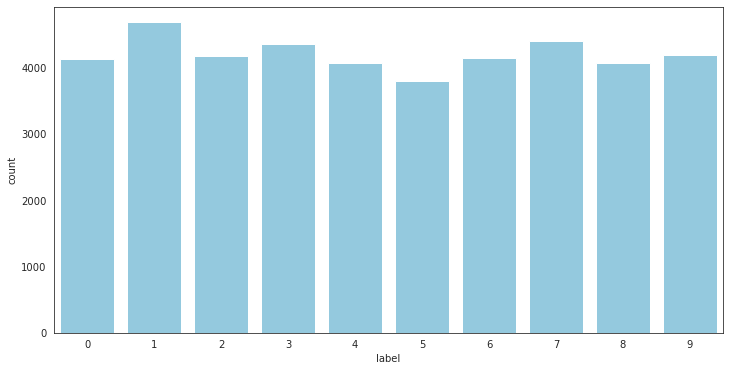

In [5]:
# segregate training data set in pixel features and label
y = data_set['label']
X = data_set.drop(labels = ['label'], axis=1) 
# free memory
del data_set

# check distribution of the handwritten digits
sns.countplot(y, color='skyblue');

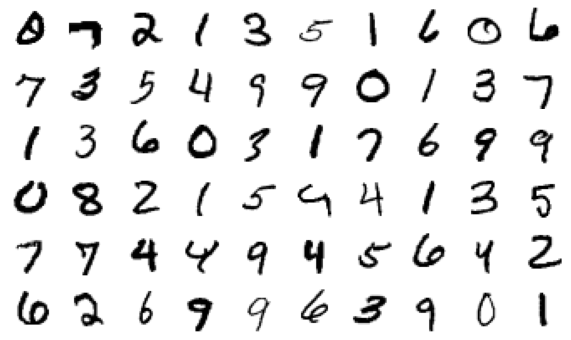

In [6]:
# show multiple images chosen randomly 
fig, axs = plt.subplots(6, 10, figsize=(10, 6)) # 6 rows of 10 images

for ax in axs.flat:
    i = randrange(X.shape[0])
    ax.imshow(X.loc[i].values.reshape(28, 28), cmap='gray_r')
    ax.set_axis_off()

In [7]:
# Normalize pixel value to range 0 to 1
X = X / 255.0

# extract train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = validation_ratio)

In [8]:
# define model
mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_shape=(784,)))
mlp.add(Dense(64, activation='sigmoid'))  
mlp.add(Dense(10, activation='softmax'))

mlp.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['acc'],
)

mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Train the model

#define callbacks
early_stop = EarlyStopping(monitor = 'val_acc', mode = 'max', patience=5, restore_best_weights=True)

history = mlp.fit(
    X_train,
    to_categorical(y_train),
    epochs = n_epochs,  
    validation_data = (X_val, to_categorical(y_val)),
    batch_size = 32,
    callbacks = [early_stop]
)

Epoch 1/30
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0040 - acc: 0.9988 - val_loss: 0.1121 - val_acc: 0.9757
Epoch 2/30
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0019 - acc: 0.9997 - val_loss: 0.1203 - val_acc: 0.9752
Epoch 3/30
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0064 - acc: 0.9982 - val_loss: 0.1164 - val_acc: 0.9774
Epoch 4/30
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0064 - acc: 0.9979 - val_loss: 0.1260 - val_acc: 0.9736
Epoch 5/30
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.1392 - val_acc: 0.9733
Epoch 6/30
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.1255 - val_acc: 0.9752
Epoch 7/30
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0078 - acc: 0.9974 - val_loss: 0.1228 - val_acc: 0.9752
Epoch 8/30
1182/1182 [==============================] - 3s 2ms

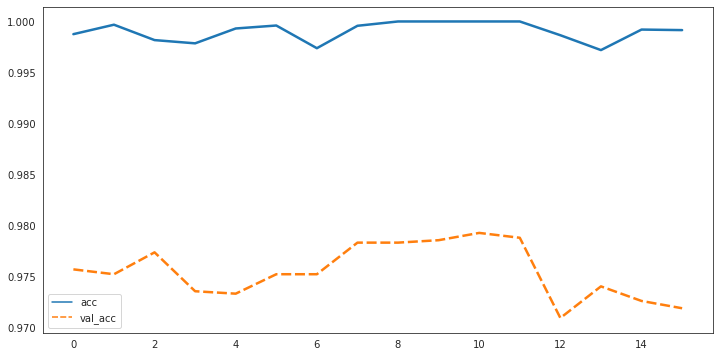

In [11]:
# compare accuracy accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['acc','val_acc']], palette="tab10", linewidth=2.5);

In [12]:
start=time()

# define a function to create model, required for KerasClassifier
# the function takes drop_out rate as argument so we can optimize it  
def create_mlp_model(dropout_rate=0):
    # create model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,))) 
    # add a dropout layer if rate is not null
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))        
    model.add(Dense(64, activation='sigmoid')) 
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))           
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['acc'],
        )    
    return model

# define function to display the results of the grid search
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))    
    
# create model
model = KerasClassifier(build_fn=create_mlp_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [n_epochs_cv],
    'dropout_rate': [0.0, 0.10, 0.20, 0.30],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)
grid_result = grid.fit(X, to_categorical(y))  # fit the full dataset as we are using cross validation 

# print out results
print('time for grid search = {:.0f} sec'.format(time()-start))
display_cv_results(grid_result)

exception calling callback for <Future at 0x7ff84c0e0370 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/jeff/anaconda3/envs/tf-gpu-apps-102920/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/jeff/anaconda3/envs/tf-gpu-apps-102920/lib/python3.8/site-packages/joblib/parallel.py", line 366, in __call__
    self.parallel.dispatch_next()
  File "/home/jeff/anaconda3/envs/tf-gpu-apps-102920/lib/python3.8/site-packages/joblib/parallel.py", line 799, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/jeff/anaconda3/envs/tf-gpu-apps-102920/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/jeff/anaconda3/envs/tf-gpu-apps-102920/lib/python3.8/site-packages/joblib/parallel.py", line 784, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/h

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6)}

In [16]:
# reload best model
mlp = grid_result.best_estimator_ 

# retrain best model on the full training set 
history = mlp.fit(
    X_train,
    to_categorical(y_train),
    validation_data = (X_val, to_categorical(y_val)),
    epochs = n_epochs,
    callbacks = [early_stop]    
)

NameError: name 'grid_result' is not defined

In [ ]:
# get prediction on validation dataset 
y_pred = mlp.predict(X_val)
print('Accuracy on validation data = {:.4f}'.format(accuracy_score(y_val, y_pred)))

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

In [ ]:
# load test data and make prediction
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
y_test = mlp.predict(test)

In [ ]:
# convert prediction to df
submission = pd.DataFrame(data=y_test)

# set label as the 0-9 class with highest value 
submission['Label'] = submission.idxmax(axis=1)
submission['ImageId'] = np.asarray([i+1 for i in range(submission.shape[0])])

submission.to_csv('submission-mlp_dropout.csv', 
                  columns=['ImageId','Label'],
                  header=True,
                  index=False)



In [17]:


# Reshape the images
img_size = 28
X_cnn = X.values.reshape(-1, img_size, img_size, 1)
# check 
print(X_cnn.shape)

X_train, X_val, y_train, y_val = train_test_split(X_cnn, y, test_size = validation_ratio)



(42000, 28, 28, 1)


In [18]:
# function to create the model for Keras wrapper to scikit learn
# we will optimize the type of pooling layer (max or average) and the activation function of the 2nd and 3rd convolution layers 
def create_cnn_model(pool_type='max', conv_activation='sigmoid', dropout_rate=0.10):
    # create model
    model = Sequential()
    
    # first layer: convolution
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) 
        
    # second series of layers: convolution, pooling, and dropout
    model.add(Conv2D(32, kernel_size=(5, 5), activation=conv_activation))  
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
    
    # third series of layers: convolution, pooling, and dropout    
    model.add(Conv2D(64, kernel_size=(3, 3), activation=conv_activation))   # 32   
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
      
    # fourth series
    model.add(Flatten())         
    model.add(Dense(64, activation='sigmoid')) # 64
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate)) 
        
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model

cnn = create_cnn_model()

cnn.compile(
  optimizer='adam',
  loss='categorical_crossentropy',  
  metrics=['accuracy'],
)

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 64)         

In [19]:
# Train the default CNN model
history = cnn.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_val, to_categorical(y_val)), 
    batch_size=32,
    callbacks = [early_stop]
)

Epoch 1/30
1182/1182 [==============================] - 5s 4ms/step - loss: 0.5066 - accuracy: 0.8523 - val_loss: 0.1230 - val_accuracy: 0.9629
Epoch 2/30
1182/1182 [==============================] - 5s 4ms/step - loss: 0.1061 - accuracy: 0.9701 - val_loss: 0.0780 - val_accuracy: 0.9767
Epoch 3/30
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0724 - accuracy: 0.9790 - val_loss: 0.0669 - val_accuracy: 0.9790
Epoch 4/30
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0572 - accuracy: 0.9831 - val_loss: 0.0549 - val_accuracy: 0.9812
Epoch 5/30
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0485 - accuracy: 0.9855 - val_loss: 0.0569 - val_accuracy: 0.9812
Epoch 6/30
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0400 - accuracy: 0.9877 - val_loss: 0.0467 - val_accuracy: 0.9850
Epoch 7/30
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0332 - accuracy: 0.9896 - val_loss: 0.0495 - val_accuracy:

In [1]:
# optimize model 
start = time()

# create model
model = KerasClassifier(build_fn=create_cnn_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'pool_type': ['max', 'average'],
    'conv_activation': ['sigmoid', 'tanh'],    
    'epochs': [n_epochs_cv],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)
grid_result = grid.fit(X_train, to_categorical(y_train))

# summarize results
print('time for grid search = {:.0f} sec'.format(time()-start))
display_cv_results(grid_result)

NameError: name 'time' is not defined

In [21]:
# optimize parameters of the fit method 
cnn_model = create_cnn_model(pool_type = grid_result.best_params_['pool_type'],
                             conv_activation = grid_result.best_params_['conv_activation'])

# With data augmentation 
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode='constant', cval = 0.0)

datagen.fit(X_train)

history = cnn_model.fit_generator(datagen.flow(X_train,to_categorical(y_train), batch_size=32),
                                  epochs = n_epochs, 
                                  validation_data = (X_val,to_categorical(y_val)),
                                  verbose = 1, 
                                  steps_per_epoch = X_train.shape[0] / 32,
                                  callbacks = [early_stop])

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

NameError: name 'grid_result' is not defined

In [ ]:
# optimize parameters of the fit method 
cnn_model = create_cnn_model(pool_type = grid_result.best_params_['pool_type'],
                             conv_activation = grid_result.best_params_['conv_activation'], 
                            dropout_rate=0.0)

#define early stop on the accuracy as this is the metric we want to improve
early_stop = EarlyStopping(monitor = 'accuracy', mode = 'max', patience=5, restore_best_weights=True)
history = cnn_model.fit_generator(datagen.flow(X_train,to_categorical(y_train), batch_size=32),
                                  epochs = n_epochs, 
                                  validation_data = (X_val,to_categorical(y_val)),
                                  verbose = 1, 
                                  steps_per_epoch = X_train.shape[0] / 32,
                                  callbacks = [early_stop])

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

In [ ]:
# save weights
cnn_model.save_weights('mnist_cnn.h5')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

X_test = test.values.reshape(-1, img_size, img_size, 1)
y_test = cnn_model.predict(X_test)

# convert to df
submission = pd.DataFrame(data=y_test)

# set label as the 0-9 class with highest value 
submission['Label'] = submission.idxmax(axis=1)
submission['ImageId'] = np.asarray([i+1 for i in range(submission.shape[0])])

submission.to_csv('submission-cnn.csv', 
                  columns=['ImageId','Label'],
                  header=True,
                  index=False)

In [7]:
# Reshape the images
img_size = 28
X_cnn = X.values.reshape(-1, img_size, img_size, 1)
# check 
print(X_cnn.shape)

X_train, X_val, y_train, y_val = train_test_split(X_cnn, y, test_size = validation_ratio)

NameError: name 'X' is not defined

In [5]:
# function to create the model for Keras wrapper to scikit learn
# we will optimize the type of pooling layer (max or average) and the activation function of the 2nd and 3rd convolution layers 
def create_cnn_model(pool_type='max', conv_activation='sigmoid', dropout_rate=0.10):
    # create model
    model = Sequential()
    
    # first layer: convolution
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) 
        
    # second series of layers: convolution, pooling, and dropout
    model.add(Conv2D(32, kernel_size=(5, 5), activation=conv_activation))  
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
    
    # third series of layers: convolution, pooling, and dropout    
    model.add(Conv2D(64, kernel_size=(3, 3), activation=conv_activation))   # 32   
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
      
    # fourth series
    model.add(Flatten())         
    model.add(Dense(64, activation='sigmoid')) # 64
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate)) 
        
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model

cnn = create_cnn_model()

cnn.compile(
  optimizer='adam',
  loss='categorical_crossentropy',  
  metrics=['accuracy'],
)

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        12832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0